# Propuesta Proyecto RecSys 2025

Integrantes: Felipe Abarca, Nicolas Estevez, Alfredo Enrione

## Setup Datos

In [2]:
from IPython.display import clear_output
!pip install datasets
clear_output()
NUM_SAMPLES = 10000 

In [3]:
from datasets import load_dataset, load_from_disk
dataset_name = "amazon_reviews_books"
try:
    reviews = load_from_disk(dataset_name)
except:
    reviews = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Books", trust_remote_code=True)
    reviews.save_to_disk(dataset_name)
    reviews.cleanup_cache_files()

#try:
#  metadata = load_from_disk("metadata")
#except:
#  metadata = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Books", trust_remote_code=True)
#  metadata.save_to_disk("metadata")
#  metadata.cleanup_cache_files()

Loading dataset from disk:   0%|          | 0/33 [00:00<?, ?it/s]

## Corriendo el modelo

In [4]:
import warnings
from loader import Loader
from utils import run_experiments
warnings.filterwarnings("ignore")

config = {
    'reg_p': 20,
    'alpha': 0.2,
    'beta': 0.3,
    'drop_p': 0.5,
    'xi': 0.3,
    'eta': 10
}
gamma = 0.5
alpha = 0.5
k_values = [10, 20]


## Amazon Books Reviews

In [5]:
loader = Loader(number_of_samples=NUM_SAMPLES) # By default, it uses the amazon_reviews_books dataset
results_books = run_experiments(loader, config, gamma, alpha, k_values)

Loading dataset from disk:   0%|          | 0/33 [00:00<?, ?it/s]

Metrics @ 10 for model pipeline (normalization=RLAE): {'precision@10': 0.0, 'recall@10': 0.0, 'ndcg@10': 0.0}
Metrics @ 20 for model pipeline (normalization=RLAE): {'precision@20': 0.0005000000000000001, 'recall@20': 0.0021234939759036146, 'ndcg@20': 0.0007947691394405591}
Metrics @ 10 for model combine (normalization=EASE): {'precision@10': 0.0, 'recall@10': 0.0, 'ndcg@10': 0.0}
Metrics @ 20 for model combine (normalization=EASE): {'precision@20': 0.0001666666666666667, 'recall@20': 4.4444444444444447e-05, 'ndcg@20': 0.00010954990189192333}
Metrics @ 10 for model regularization (normalization=LAE): {'precision@10': 0.0, 'recall@10': 0.0, 'ndcg@10': 0.0}
Metrics @ 20 for model regularization (normalization=LAE): {'precision@20': 0.0, 'recall@20': 0.0, 'ndcg@20': 0.0}
Metrics @ 10 for model dan (normalization=RLAE): {'precision@10': 0.0010000000000000002, 'recall@10': 5.741461305663641e-05, 'ndcg@10': 0.0009388586263656396}
Metrics @ 20 for model dan (normalization=RLAE): {'precision@20

## Otros Dataset

### Amazon - Product


In [6]:
from datasets import load_dataset, load_from_disk
dataset_name = "amazon_products"
try:
  products = load_from_disk(dataset_name)
except:
  products = load_dataset("minhth2nh/amazon_product_review_283K", trust_remote_code=True)
  products.save_to_disk(dataset_name)
  products.cleanup_cache_files()

  print(products)

In [7]:
loader_products = Loader(dataset_name=dataset_name, subset_name="train", number_of_samples=NUM_SAMPLES, user_id_column="user_id")
results_products = run_experiments(loader_products, config, gamma, alpha, k_values)

Metrics @ 10 for model pipeline (normalization=RLAE): {'precision@10': 0.0, 'recall@10': 0.0, 'ndcg@10': 0.0}
Metrics @ 20 for model pipeline (normalization=RLAE): {'precision@20': 6.666666666666667e-05, 'recall@20': 0.0013333333333333333, 'ndcg@20': 0.0003138785511555177}
Metrics @ 10 for model combine (normalization=EASE): {'precision@10': 0.00013333333333333334, 'recall@10': 0.0002666666666666667, 'ndcg@10': 0.00014265750982301838}
Metrics @ 20 for model combine (normalization=EASE): {'precision@20': 0.00013333333333333334, 'recall@20': 0.0007111111111111111, 'ndcg@20': 0.00029908375183060386}
Metrics @ 10 for model regularization (normalization=LAE): {'precision@10': 0.00013333333333333334, 'recall@10': 0.0002666666666666667, 'ndcg@10': 0.00028531501964603677}
Metrics @ 20 for model regularization (normalization=LAE): {'precision@20': 0.00013333333333333334, 'recall@20': 0.0015999999999999999, 'ndcg@20': 0.0006355143996956282}
Metrics @ 10 for model dan (normalization=RLAE): {'prec

### YELP Reviews

In [8]:
from datasets import load_dataset, load_from_disk

dataset_name = "yelp_reviews"
try:
  products = load_from_disk(dataset_name)
except:
  products = load_dataset("yashraizada/yelp-open-dataset-reviews", trust_remote_code=True)
  products.save_to_disk(dataset_name)
  products.cleanup_cache_files()

  print(products)

In [9]:
from loader import Loader
from utils import run_experiments

loader_yelp = Loader(dataset_name="yelp_reviews", subset_name="train", number_of_samples=NUM_SAMPLES, reviews_column="stars", asin_column="business_id", user_id_column="user_id")
results_yelp =run_experiments(loader_yelp, config, gamma, alpha, k_values)

Metrics @ 10 for model pipeline (normalization=RLAE): {'precision@10': 0.0, 'recall@10': 0.0, 'ndcg@10': 0.0}
Metrics @ 20 for model pipeline (normalization=RLAE): {'precision@20': 0.00013623978201634878, 'recall@20': 0.0027247956403269754, 'ndcg@20': 0.0006414411808355265}
Metrics @ 10 for model combine (normalization=EASE): {'precision@10': 0.0, 'recall@10': 0.0, 'ndcg@10': 0.0}
Metrics @ 20 for model combine (normalization=EASE): {'precision@20': 0.0, 'recall@20': 0.0, 'ndcg@20': 0.0}
Metrics @ 10 for model regularization (normalization=LAE): {'precision@10': 0.005994550408719347, 'recall@10': 0.05994550408719346, 'ndcg@10': 0.030331947278049512}
Metrics @ 20 for model regularization (normalization=LAE): {'precision@20': 0.00449591280653951, 'recall@20': 0.08991825613079019, 'ndcg@20': 0.037795851081071676}
Metrics @ 10 for model dan (normalization=RLAE): {'precision@10': 0.0, 'recall@10': 0.0, 'ndcg@10': 0.0}
Metrics @ 20 for model dan (normalization=RLAE): {'precision@20': 0.0, 'r

## Metrics Plot

In [1]:
import pandas as pd
try:
    results_df = pd.DataFrame(results_yelp + results_products + results_books)
except NameError:
    results_df = pd.read_csv("results.csv")
print(results_df)
results_df.to_csv("results.csv", index=False)

                 dataset           model normalization   k  precision  \
0           yelp_reviews        pipeline          RLAE  10   0.000000   
1           yelp_reviews        pipeline          RLAE  20   0.000136   
2           yelp_reviews         combine          EASE  10   0.000000   
3           yelp_reviews         combine          EASE  20   0.000000   
4           yelp_reviews  regularization           LAE  10   0.005995   
5           yelp_reviews  regularization           LAE  20   0.004496   
6           yelp_reviews             dan          RLAE  10   0.000000   
7           yelp_reviews             dan          RLAE  20   0.000000   
8           yelp_reviews         sapling           NaN  10   0.003815   
9           yelp_reviews         sapling           NaN  20   0.003270   
10          yelp_reviews             dan          EASE  10   0.000000   
11          yelp_reviews             dan          EASE  20   0.000000   
12       amazon_products        pipeline          R

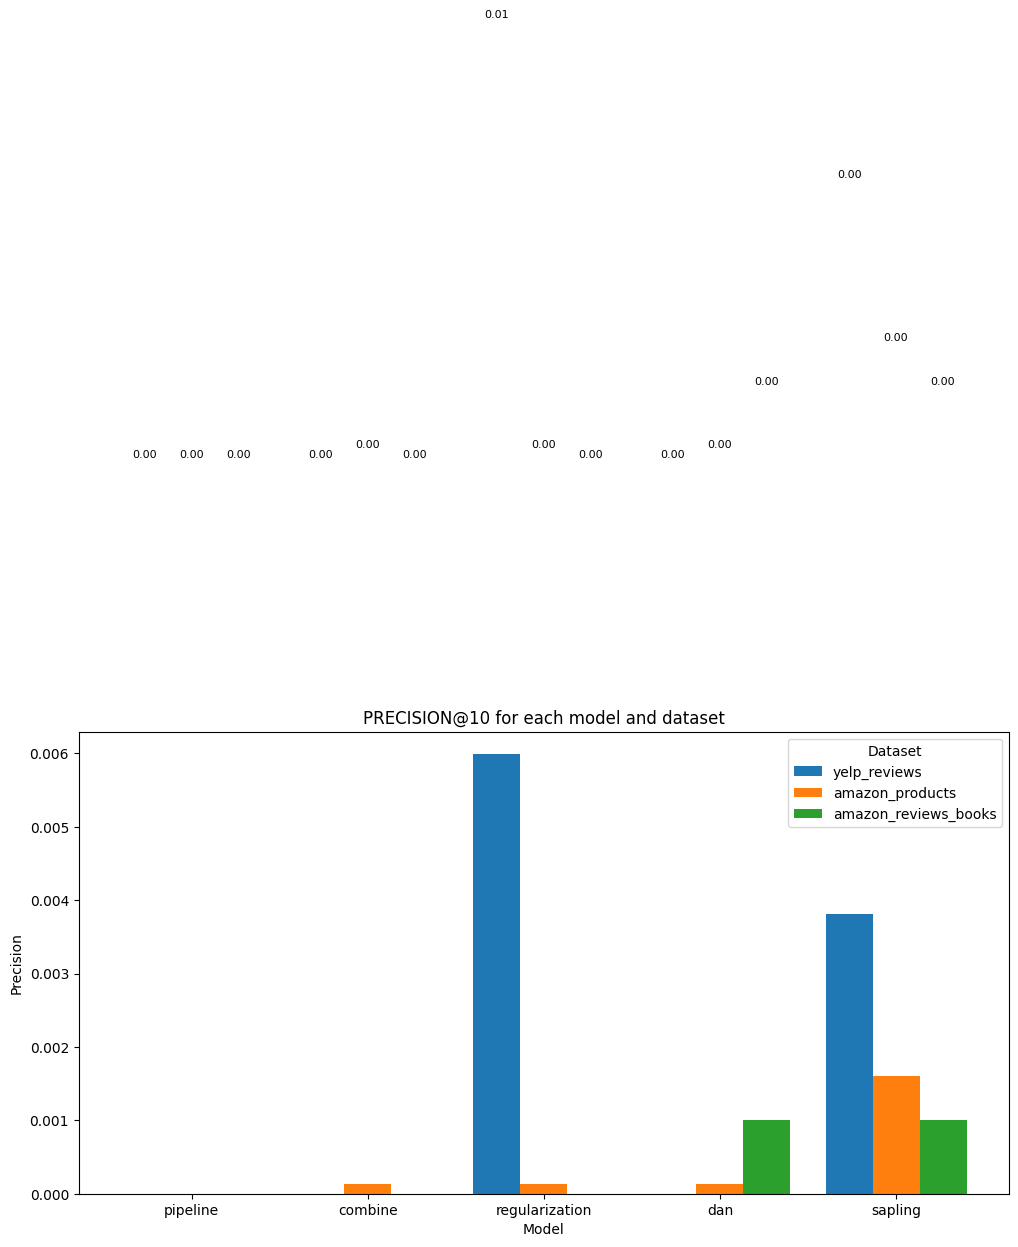

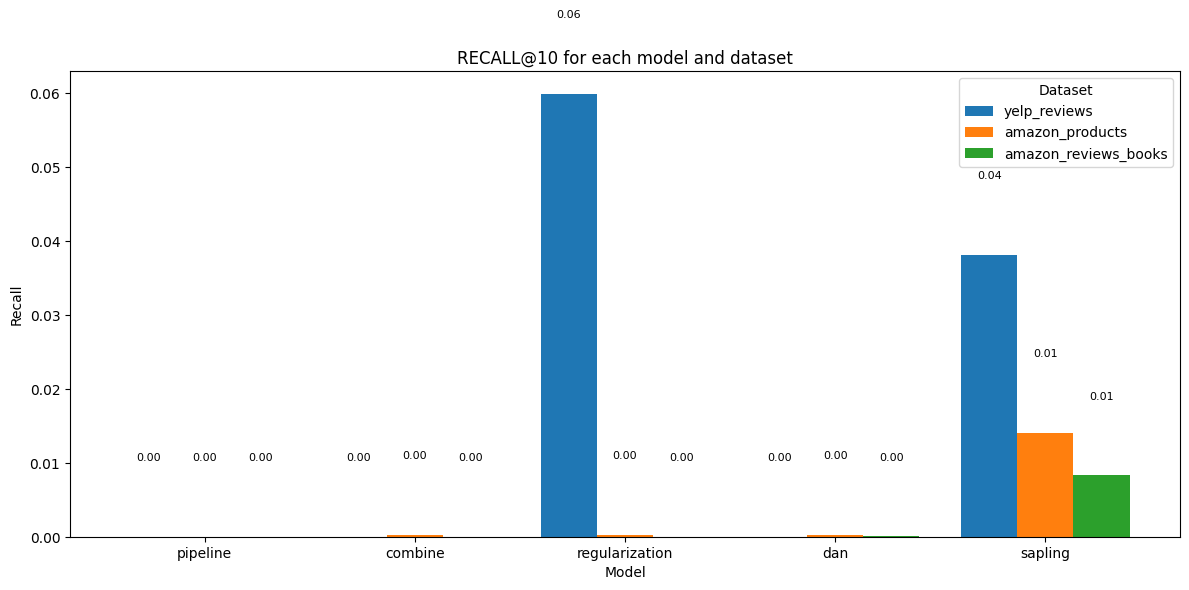

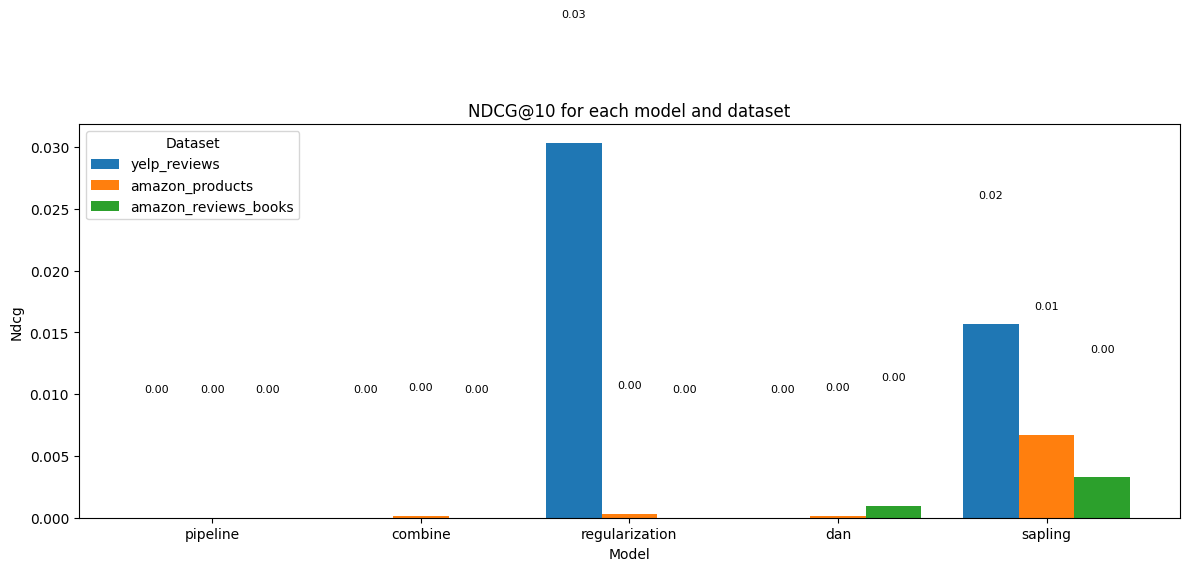

In [2]:
# Plots - k=10
from utils import plot_grouped_bar

plot_grouped_bar(results_df, "precision", 10)
plot_grouped_bar(results_df, "recall", 10)
plot_grouped_bar(results_df, "ndcg", 10)


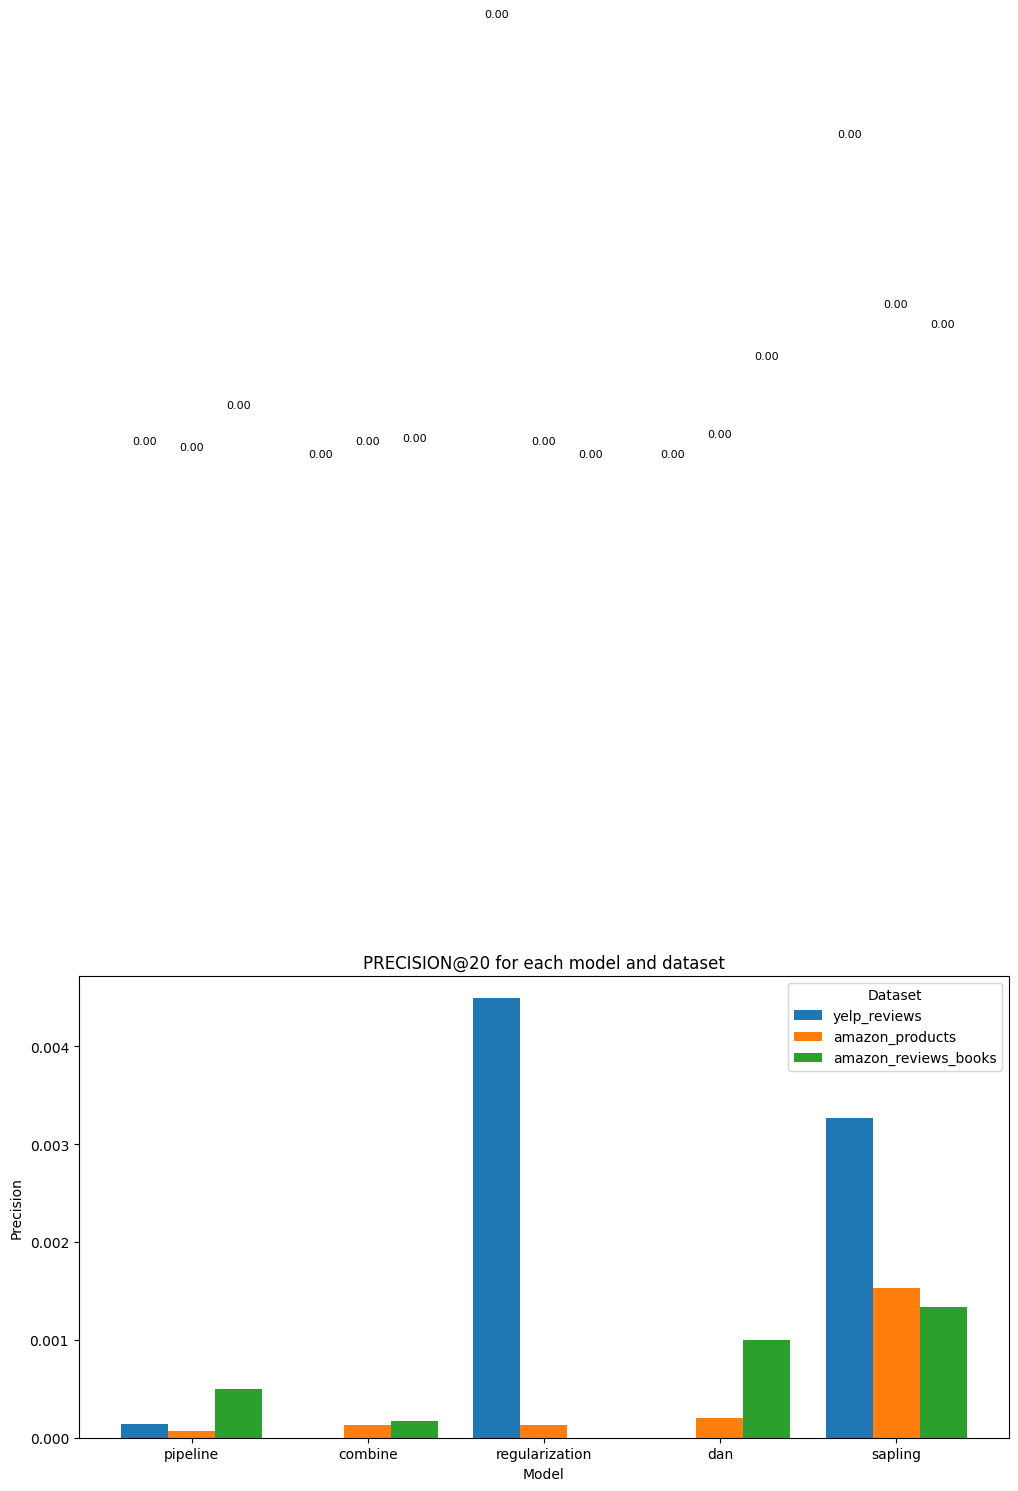

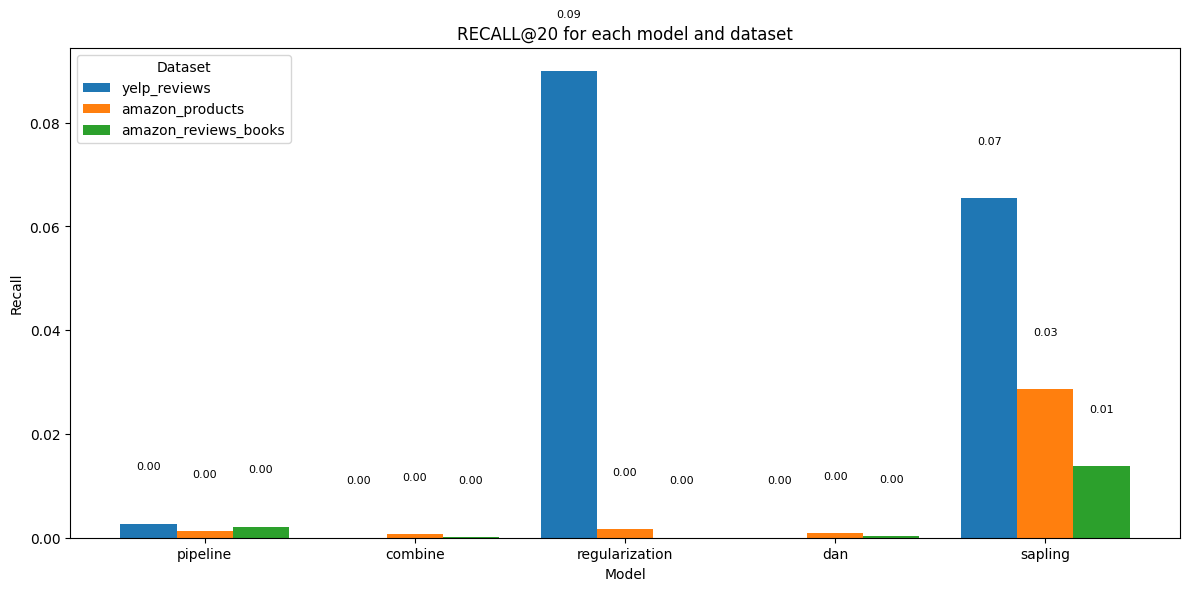

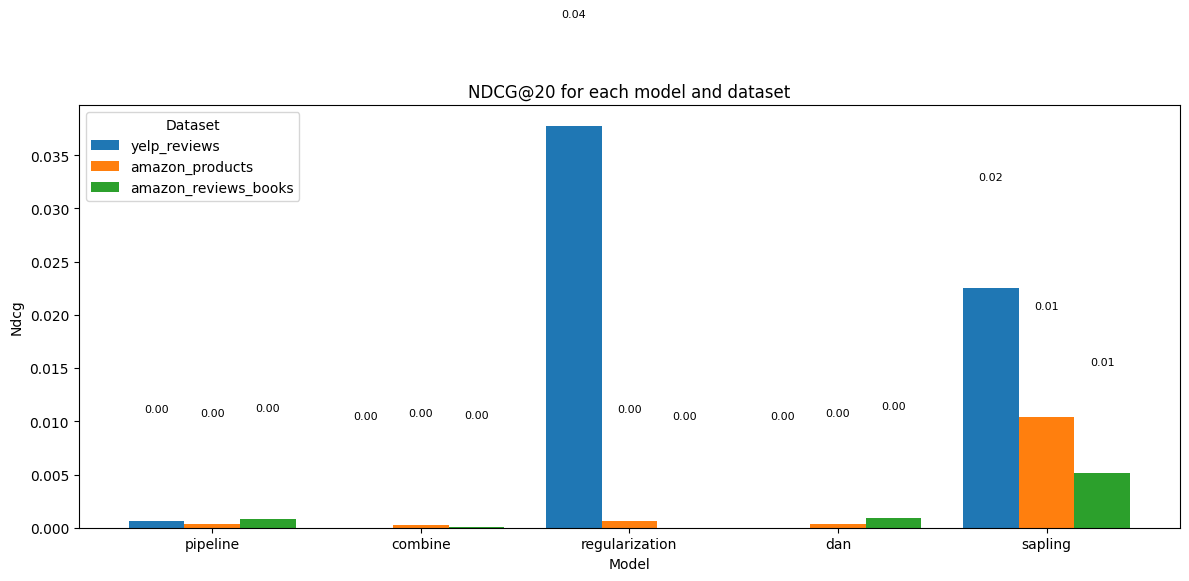

In [3]:
# Plots - k=20
plot_grouped_bar(results_df, "precision", 20)
plot_grouped_bar(results_df, "recall", 20)
plot_grouped_bar(results_df, "ndcg", 20)